In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# GRAPH SETTINGS
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

# Data

In [17]:
intent_version = 'v1'
map_nr = 'simple_kitchen'

# Directorios base
local = '/mnt/lustre/home/samuloza'
#local = ''
#local = 'C:/OneDrive - Universidad Complutense de Madrid (UCM)/Doctorado'

if intent_version is not None:
    raw_dir = f"{local}/data/samuel_lozano/cooked/classic/{intent_version}/map_{map_nr}"
else:
    raw_dir = f"{local}/data/samuel_lozano/cooked/classic/map_{map_nr}"

base_dirs = {
    "Competitive": f"{raw_dir}/competitive",
    "Cooperative": f"{raw_dir}/cooperative"
}

# Crear directorios base si no existen
for dir_path in base_dirs.values():
    os.makedirs(dir_path, exist_ok=True)

output_path = f"{raw_dir}/training_results.csv"
figures_dir = f"{raw_dir}/figures/"

# Crear también el directorio para las figuras si no existe
os.makedirs(figures_dir, exist_ok=True)

# Eliminar el archivo CSV si ya existe
if os.path.exists(output_path):
    os.remove(output_path)

In [18]:
all_dfs = []

# Patrón para capturar los coeficientes de recompensa
reward_pattern = re.compile(
    r"'([^']+)':\s*\(\s*([-\d\.eE+]+),\s*([-\d\.eE+]+)\)"
)

In [19]:
for game_type, base_dir in base_dirs.items():
    game_flag = 1 if "Cooperative" in game_type else 0
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        date_time_str = folder.replace("Training_", "")
        config_path = os.path.join(folder_path, "config.txt")
        csv_path = os.path.join(folder_path, "training_stats.csv")

        if not (os.path.exists(config_path) and os.path.exists(csv_path)):
            continue

        with open(config_path, "r") as f:
            config_contents = f.read()
        match = reward_pattern.findall(config_contents)
        if not match:
            continue

        (name_1, alpha_1, beta_1), (name_2, alpha_2, beta_2) = match
        alpha_1, beta_1 = float(alpha_1), float(beta_1) 
        alpha_2, beta_2 = float(alpha_2), float(beta_2)

        lr_match = re.search(r"LR:\s*([0-9.eE+-]+)", config_contents)
        lr = float(lr_match.group(1)) 

        with open(csv_path, 'r') as f:
            lines = f.readlines()
        header = lines[0]
        filtered_lines = [header] + [line for line in lines[1:] if not line.startswith("episode,env")]

        from io import StringIO
        df = pd.read_csv(StringIO("".join(filtered_lines)))

        df.iloc[:, 0] = range(1, len(df) + 1)

        df.insert(0, "timestamp", date_time_str)
        df.insert(1, "game_type", game_flag)
        df.insert(2, "alpha_1", alpha_1)
        df.insert(3, "beta_1", beta_1)
        df.insert(4, "alpha_2", alpha_2)
        df.insert(5, "beta_2", beta_2)
        df.insert(6, "lr", lr)

        all_dfs.append(df)

In [20]:
# Concatenar todos los resultados
final_df = pd.concat(all_dfs, ignore_index=True)
final_df.to_csv(output_path, index=False)

# Visualization

In [21]:
# Leer el CSV especificando los tipos de datos
dtype_dict = {
    "timestamp": str,
    "game_type": int,
    "alpha_1": float,
    "beta_1": float,
    "alpha_2": float,
    "beta_2": float
}

df = pd.read_csv(output_path, dtype=dtype_dict, low_memory=False)
for col in df.columns[6:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Crear una columna identificadora de combinación de coeficientes
df = df.sort_values(by=["alpha_1", "alpha_2"], ascending=[False, False])
df["attitude_key"] = df.apply(lambda row: f"{row['alpha_1']}_{row['beta_1']}_{row['alpha_2']}_{row['beta_2']}", axis=1)
df["pure_reward_total"] = df["pure_reward_ai_rl_1"] + df["pure_reward_ai_rl_2"]

df["total_deliveries"] = np.where(
    df["game_type"] == 1,
    df["total_deliveries_ai_rl_1"],
    df["total_deliveries_ai_rl_2"] + df["total_deliveries_ai_rl_2"]
)

In [ ]:
# Filtrar todas las combinaciones únicas
unique_attitudes = df["attitude_key"].unique()
unique_lr = df["lr"].unique()
unique_game_type = df["game_type"].unique()

os.makedirs(figures_dir, exist_ok=True)

rewarded_metrics_1 = [
    "delivered_ai_rl_1",
    "cut_ai_rl_1",
    "salad_ai_rl_1",
]

rewarded_metrics_2 = [
    "delivered_ai_rl_2",
    "cut_ai_rl_2",
    "salad_ai_rl_2",
]

rewarded_metric_labels = {
    "delivered": "Delivered",
    "cut": "Cut",
    "salad": "Salad"
}

rewarded_metric_colors = {
    "delivered": "#27AE60",
    "cut": "#2980B9",
    "salad": "#E67E22"
}

action_types_1 = [
    "do_nothing_ai_rl_1",
    "floor_actions_ai_rl_1",
    "wall_actions_ai_rl_1",
    "useless_counter_actions_ai_rl_1",
    "useful_counter_actions_ai_rl_1",
    "useless_food_dispenser_actions_ai_rl_1",
    "useful_food_dispenser_actions_ai_rl_1",
    "useless_cutting_board_actions_ai_rl_1",
    "useful_cutting_board_actions_ai_rl_1",
    "useless_plate_dispenser_actions_ai_rl_1",
    "useful_plate_dispenser_actions_ai_rl_1",
    "useless_delivery_actions_ai_rl_1",
    "useful_delivery_actions_ai_rl_1",
]

action_types_2 = [
    "do_nothing_ai_rl_2",
    "floor_actions_ai_rl_2",
    "wall_actions_ai_rl_2",
    "useless_counter_actions_ai_rl_2",
    "useful_counter_actions_ai_rl_2",
    "useless_food_dispenser_actions_ai_rl_2",
    "useful_food_dispenser_actions_ai_rl_2",
    "useless_cutting_board_actions_ai_rl_2",
    "useful_cutting_board_actions_ai_rl_2",
    "useless_plate_dispenser_actions_ai_rl_2",
    "useful_plate_dispenser_actions_ai_rl_2",
    "useless_delivery_actions_ai_rl_2",
    "useful_delivery_actions_ai_rl_2",
]

action_types_labels = {
    "do_nothing": "No action",
    "floor_actions": "Floor",
    "wall_actions": "Wall",
    "useless_counter_actions": "Useless Counter",
    "useful_counter_actions": "Useful Counter",
    "useless_food_dispenser_actions": "Useless Food Dispenser",
    "useful_food_dispenser_actions": "Useful Food Dispenser",
    "useless_cutting_board_actions": "Useless Cutting Board",
    "useful_cutting_board_actions": "Useful Cutting Board",
    "useless_plate_dispenser_actions": "Useless Plate Dispenser",
    "useful_plate_dispenser_actions": "Useful Plate Dispenser",
    "useless_delivery_actions": "Useless Delivery",
    "useful_delivery_actions": "Useful Delivery",
}

action_types_colors = {
    "do_nothing": "#000000",  # negro
    # floor & wall (colores random porque nunca aparecen)
    "floor_actions": "#9B59B6",  # morado random
    "wall_actions": "#59351F",   # marrón random
    # Counter (gris)
    "useless_counter_actions": "#D5D8DC",  # gris claro
    "useful_counter_actions": "#7B7D7D",   # gris oscuro
    # Food dispenser (rojo)
    "useless_food_dispenser_actions": "#F5B7B1",  # rojo claro
    "useful_food_dispenser_actions": "#C0392B",   # rojo oscuro
    # Cutting board (azul)
    "useless_cutting_board_actions": "#AED6F1",  # azul claro
    "useful_cutting_board_actions": "#2980B9",   # azul oscuro
    # Plate dispenser (naranja)
    "useless_plate_dispenser_actions": "#FAD7A0",  # naranja claro
    "useful_plate_dispenser_actions": "#E67E22",   # naranja oscuro
    # Delivery (verde)
    "useless_delivery_actions": "#A9DFBF",  # verde claro
    "useful_delivery_actions": "#27AE60",  # verde normal
}

## General visuals (not smoothed)

In [23]:
# Print Pure total reward vs epoch

for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]

    plt.figure(figsize=(10, 6))
    
    for game_type in unique_game_type:
        game_type_filtered = subset[subset["game_type"] == game_type]
    
        # Filtrar por tasa de aprendizaje
        for lr in unique_lr:
            lr_filtered = game_type_filtered[game_type_filtered["lr"] == lr]
            grouped = lr_filtered.groupby("epoch")["pure_reward_total"].mean().reset_index()
            label = f"Game Type {game_type}, LR {lr}"
            plt.plot(grouped["epoch"], grouped["pure_reward_total"], label=label)
    
    # Añadir detalles
    plt.title(f"Pure Reward vs Epoch\nAttitude {attitude}")
    plt.xlabel("Epoch")
    #plt.xlim([0,100])
    plt.ylabel("Pure Reward Total")
    plt.legend()
    plt.tight_layout()
    
    sanitized_attitude = attitude.replace('.', 'p')
    filename = f"pure_reward_attitude_{sanitized_attitude}.png"
    filepath = os.path.join(figures_dir, filename)
    plt.savefig(filepath)
    plt.close()

In [24]:
# Print Each agent pure total reward vs epoch

for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]

    for game_type in unique_game_type:
        game_type_filtered = subset[subset["game_type"] == game_type]
    
        # Crear la figura
        plt.figure(figsize=(10, 6))
    
        # Filtrar por tasa de aprendizaje
        for lr in unique_lr:    
            lr_filtered = game_type_filtered[game_type_filtered["lr"] == lr]
            grouped = lr_filtered.groupby("epoch")[["pure_reward_ai_rl_1", "pure_reward_ai_rl_2"]].mean().reset_index()
            label_0 = f"Agent 1, LR {lr}"
            label_1 = f"Agent 2, LR {lr}"
            plt.plot(grouped["epoch"], grouped["pure_reward_ai_rl_1"], label=label_0)
            plt.plot(grouped["epoch"], grouped["pure_reward_ai_rl_2"], label=label_1)
    
        # Añadir detalles
        plt.title(f"Pure Reward vs Epoch\nAttitude {attitude}, Game Type {game_type}")
        plt.xlabel("Epoch")
        #plt.xlim([0,100])
        plt.ylabel("Pure Reward Total")
        plt.legend()
        plt.tight_layout()
        
        sanitized_attitude = attitude.replace('.', 'p')
        filename = f"pure_reward_agents_g{game_type}_attitude_{sanitized_attitude}.png"
        filepath = os.path.join(figures_dir, filename)
        plt.savefig(filepath)
        plt.close()

In [ ]:
# Print agent metrics vs epoch
for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]

    att_parts = attitude.split('_')
    att0_title = f"{att_parts[0]}_{att_parts[1]}"
    att1_title = f"{att_parts[2]}_{att_parts[3]}"

    for game_type in [0, 1]:
        for lr in subset["lr"].unique():
            filtered_subset = subset[(subset["game_type"] == game_type) & (subset["lr"] == lr)]
    
            plt.figure(figsize=(12, 6))
            for metric in rewarded_metrics_1:
                grouped = filtered_subset.groupby(["epoch"])[metric].mean().reset_index()
                plt.plot(grouped["epoch"], grouped[metric], label=metric.replace("_", " ").title())
            plt.title(f"Metrics per Epoch - Game Type {game_type}, LR {lr}, Attitude {att0_title}")
            plt.xlabel("Epoch")
            plt.ylabel("Mean value")
            plt.legend()
            #plt.xlim([0, 100])
            plt.tight_layout()
            
            sanitized_attitude = attitude.replace('.', 'p')
            filename_1 = f"rewarded_metrics_agent1_g{game_type}_lr{str(lr).replace('.', 'p')}_attitude_{sanitized_attitude}.png"
            filepath_1 = os.path.join(figures_dir, filename_1)
            plt.savefig(filepath_1)
            plt.close()
    
            plt.figure(figsize=(12, 6))
            for metric in rewarded_metrics_2:
                grouped = filtered_subset.groupby(["epoch"])[metric].mean().reset_index()
                plt.plot(grouped["epoch"], grouped[metric], label=metric.replace("_", " ").title())
            plt.title(f"Metrics per Epoch - Game Type {game_type}, LR {lr}, Attitude {att1_title}")
            plt.xlabel("Epoch")
            plt.ylabel("Mean value")
            plt.legend()
            #plt.xlim([0, 100])
            plt.tight_layout()

            filename_2 = f"rewarded_metrics_agent2_g{game_type}_lr{str(lr).replace('.', 'p')}_attitude_{sanitized_attitude}.png"
            filepath_2 = os.path.join(figures_dir, filename_2)
            plt.savefig(filepath_2)
            plt.close()

# Smoothed

In [26]:
N = 15

smoothed_figures_dir = f"{figures_dir}/smoothed_{N}/"
os.makedirs(smoothed_figures_dir, exist_ok=True)

In [27]:
# Print Pure total reward vs epoch

plt.figure(figsize=(10, 6))

for game_type in unique_game_type:
    game_type_filtered_df = df[df["game_type"] == game_type]

    # Filtrar por tasa de aprendizaje
    for lr in unique_lr:
        lr_filtered_df = game_type_filtered_df[game_type_filtered_df["lr"] == lr]
        lr_filtered_df["epoch_block"] = (lr_filtered_df["epoch"] // N)
        block_means = lr_filtered_df.groupby("epoch_block")["pure_reward_total"].mean()
        middle_epochs = lr_filtered_df.groupby("epoch_block")["epoch"].median()

        if game_type == 0:
            label = f"Competitive"
            color = "red"
        else:
            label = f"Cooperative"
            color = "green"
        
        plt.plot(middle_epochs, block_means, label=label, color=color)

# Añadir detalles
plt.xlabel("Epochs", fontsize=20)
#plt.xlim([0,100])
plt.ylabel("Mean total reward", fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

filename = f"pure_reward_smoothed_{N}.png"
filepath = os.path.join(smoothed_figures_dir, filename)
plt.savefig(filepath)
plt.close()

In [28]:
# Print Each agent pure total reward vs epoch

for game_type in unique_game_type:
    game_type_filtered = df[df["game_type"] == game_type]

    # Crear la figura
    plt.figure(figsize=(10, 6))

    # Filtrar por tasa de aprendizaje
    for lr in unique_lr:
        lr_filtered = game_type_filtered[game_type_filtered["lr"] == lr]
        lr_filtered["epoch_block"] = (lr_filtered["epoch"] // N)
        block_means_1 = lr_filtered.groupby("epoch_block")["pure_reward_ai_rl_1"].mean()
        block_means_2 = lr_filtered.groupby("epoch_block")["pure_reward_ai_rl_2"].mean()
        middle_epochs = lr_filtered.groupby("epoch_block")["epoch"].median()

        label_1 = f"Agent 1, LR {lr}"
        label_2 = f"Agent 2, LR {lr}"
        plt.plot(middle_epochs, block_means_1, label=label_1)
        plt.plot(middle_epochs, block_means_2, label=label_2)

    # Añadir detalles
    plt.title(f"Pure Reward vs Epoch\nGame Type {game_type}")
    plt.xlabel("Epoch")
    #plt.xlim([0,100])
    plt.ylabel("Pure Reward Total")
    plt.legend()
    plt.tight_layout()
    
    filename = f"pure_reward_agents_g{game_type}_smoothed_{N}.png"
    filepath = os.path.join(smoothed_figures_dir, filename)
    plt.savefig(filepath)
    plt.close()

In [29]:
# Print Each agent modified total reward vs epoch

for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]

    for game_type in unique_game_type:
        game_type_filtered = subset[subset["game_type"] == game_type]
    
        # Crear la figura
        plt.figure(figsize=(10, 6))
    
        # Filtrar por tasa de aprendizaje
        for lr in unique_lr:
            lr_filtered = game_type_filtered[game_type_filtered["lr"] == lr]
            lr_filtered["epoch_block"] = (lr_filtered["epoch"] // N)
            block_means_1 = lr_filtered.groupby("epoch_block")["modified_reward_ai_rl_1"].mean()
            block_means_2 = lr_filtered.groupby("epoch_block")["modified_reward_ai_rl_2"].mean()
            middle_epochs = lr_filtered.groupby("epoch_block")["epoch"].median()

            label_1 = f"Agent 1, LR {lr}"
            label_2 = f"Agent 2, LR {lr}"
            plt.plot(middle_epochs, block_means_1, label=label_1)
            plt.plot(middle_epochs, block_means_2, label=label_2)
    
        # Añadir detalles
        plt.title(f"Modified Reward vs Epoch\nAttitude {attitude}, Game Type {game_type}")
        plt.xlabel("Epoch")
        #plt.xlim([0,100])
        plt.ylabel("Modified Reward Total")
        plt.legend()
        plt.tight_layout()
        
        sanitized_attitude = attitude.replace('.', 'p')
        filename = f"modified_reward_agents_g{game_type}_attitude_{sanitized_attitude}_smoothed_{N}.png"
        filepath = os.path.join(smoothed_figures_dir, filename)
        plt.savefig(filepath)
        plt.close()

In [ ]:
# Print agent rewarded metrics vs epoch

for game_type in unique_game_type:
    for lr in unique_lr:
        filtered_subset = df[(df["game_type"] == game_type) & (df["lr"] == lr)]
        filtered_subset["epoch_block"] = (filtered_subset["epoch"] // N)

        plt.figure(figsize=(12, 6))
        for metric in rewarded_metrics_1:
            block_means = filtered_subset.groupby("epoch_block")[[metric]].mean()
            middle_epochs = filtered_subset.groupby("epoch_block")["epoch"].median()
            plt.plot(middle_epochs, block_means, label=metric.replace("_", " ").title())
        plt.title(f"Metrics per Epoch - Game Type {game_type}, LR {lr}")
        plt.xlabel("Epoch")
        plt.ylabel("Mean value")
        plt.legend()
        #plt.xlim([0, 100])
        plt.tight_layout()
        
        filename_1 = f"rewarded_metrics_agent1_g{game_type}_lr{str(lr).replace('.', 'p')}_smoothed_{N}.png"
        filepath_1 = os.path.join(smoothed_figures_dir, filename_1)
        plt.savefig(filepath_1)
        plt.close()
    
        plt.figure(figsize=(12, 6))
        
        for metric in rewarded_metrics_2:
            block_means = filtered_subset.groupby("epoch_block")[[metric]].mean()
            middle_epochs = filtered_subset.groupby("epoch_block")["epoch"].median()
            plt.plot(middle_epochs, block_means, label=metric.replace("_", " ").title())
        plt.title(f"Metrics per Epoch - Game Type {game_type}, LR {lr}")
        plt.xlabel("Epoch")
        plt.ylabel("Mean value")
        plt.legend()
        #plt.xlim([0, 100])
        plt.tight_layout()

        filename_2 = f"rewarded_metrics_agent2_g{game_type}_lr{str(lr).replace('.', 'p')}_smoothed_{N}.png"
        filepath_2 = os.path.join(smoothed_figures_dir, filename_2)
        plt.savefig(filepath_2)
        plt.close()

/tmp/ipykernel_2632690/3253265060.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_subset["epoch_block"] = (filtered_subset["epoch"] // N)
/tmp/ipykernel_2632690/3253265060.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_subset["epoch_block"] = (filtered_subset["epoch"] // N)


/tmp/ipykernel_2632690/1680531892.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_subset["epoch_block"] = (filtered_subset["epoch"] // N)


KeyError: "Columns not found: 'useless_food_dispenser_actions_ai_rl_1'"

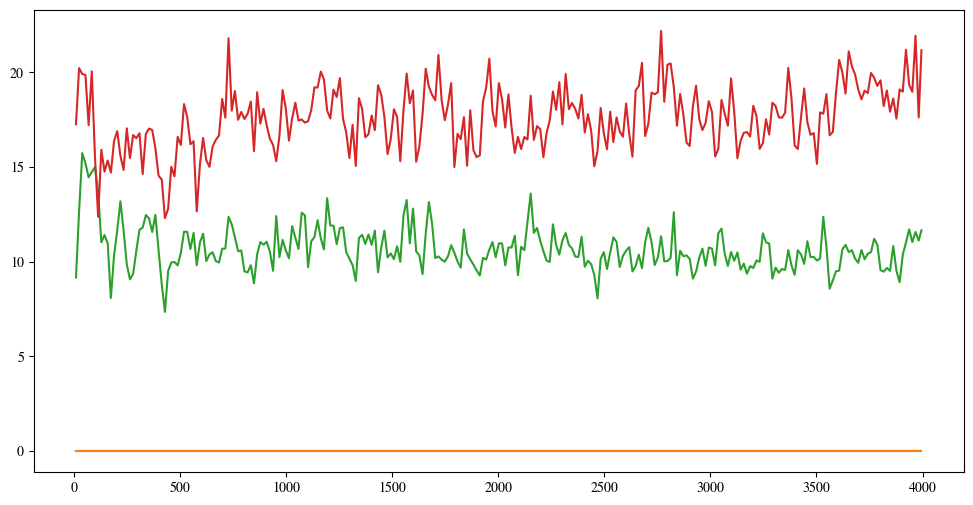

In [37]:
# Print agent metrics vs epoch

for game_type in unique_game_type:
    for lr in unique_lr:
        filtered_subset = df[(df["game_type"] == game_type) & (df["lr"] == lr)]
        filtered_subset["epoch_block"] = (filtered_subset["epoch"] // N)

        plt.figure(figsize=(12, 6))
        for metric in action_types_1:
            block_means = filtered_subset.groupby("epoch_block")[[metric]].mean()
            middle_epochs = filtered_subset.groupby("epoch_block")["epoch"].median()
            plt.plot(middle_epochs, block_means, label=metric.replace("_", " ").title())
        plt.title(f"Metrics per Epoch - Game Type {game_type}, LR {lr}")
        plt.xlabel("Epoch")
        plt.ylabel("Mean value")
        plt.legend()
        #plt.xlim([0, 100])
        plt.tight_layout()
        
        filename_1 = f"metrics_agent1_g{game_type}_lr{str(lr).replace('.', 'p')}_smoothed_{N}.png"
        filepath_1 = os.path.join(smoothed_figures_dir, filename_1)
        plt.savefig(filepath_1)
        plt.close()
    
        plt.figure(figsize=(12, 6))
        
        for metric in action_types_2:
            block_means = filtered_subset.groupby("epoch_block")[[metric]].mean()
            middle_epochs = filtered_subset.groupby("epoch_block")["epoch"].median()
            plt.plot(middle_epochs, block_means, label=metric.replace("_", " ").title())
        plt.title(f"Metrics per Epoch - Game Type {game_type}, LR {lr}")
        plt.xlabel("Epoch")
        plt.ylabel("Mean value")
        plt.legend()
        #plt.xlim([0, 100])
        plt.tight_layout()

        filename_2 = f"metrics_agent2_g{game_type}_lr{str(lr).replace('.', 'p')}_smoothed_{N}.png"
        filepath_2 = os.path.join(smoothed_figures_dir, filename_2)
        plt.savefig(filepath_2)
        plt.close()

In [32]:
# Print Pure total reward vs epoch
for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]

    plt.figure(figsize=(10, 6))
    
    for game_type in unique_game_type:
        game_type_filtered = subset[subset["game_type"] == game_type]
    
        # Filtrar por tasa de aprendizaje
        for lr in unique_lr:
            lr_filtered = game_type_filtered[game_type_filtered["lr"] == lr]
            lr_filtered["epoch_block"] = (lr_filtered["epoch"] // N)

            # Calcular la media de recompensa por bloque
            block_means = lr_filtered.groupby("epoch_block")["pure_reward_total"].mean()
            middle_epochs = lr_filtered.groupby("epoch_block")["epoch"].median()

            if game_type == 0:
                label = f"Competitive"
                color = "red"
            else:
                label = f"Cooperative"
                color = "orange"

            plt.plot(middle_epochs, block_means, label=label, color=color)
    
    # Añadir detalles
    plt.xlabel("Epochs", fontsize=20)
    #plt.xlim([0,100])
    plt.title(f"Pure Reward vs Epoch\nAttitude {attitude}")

    plt.ylabel("Mean total reward", fontsize=20)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    #plt.ylim(-140, 320)
    plt.tight_layout()
    
    sanitized_attitude = attitude.replace('.', 'p')
    filename = f"pure_reward_attitude_{sanitized_attitude}_smoothed_{N}.png"
    filepath = os.path.join(smoothed_figures_dir, filename)
    plt.savefig(filepath)
    plt.close()

### Action types

In [ ]:
# Print agent metrics vs epoch averaged by individual attitude
# First, create individual attitude keys for each agent
df['attitude_agent_1'] = df['alpha_1'].astype(str) + '_' + df['beta_1'].astype(str)
df['attitude_agent_2'] = df['alpha_2'].astype(str) + '_' + df['beta_2'].astype(str)

# Get unique individual attitudes
unique_individual_attitudes = set()
for attitude in unique_attitudes:
    att_parts = attitude.split('_') 
    unique_individual_attitudes.add(f"{att_parts[0]}_{att_parts[1]}")  # agent 1 attitude
    unique_individual_attitudes.add(f"{att_parts[2]}_{att_parts[3]}")  # agent 2 attitude

print(f"Individual attitudes found: {sorted(unique_individual_attitudes)}")

# Now create plots for each individual attitude
for individual_attitude in unique_individual_attitudes:
    att_parts = individual_attitude.split('_')
    alpha = float(att_parts[0])
    beta = float(att_parts[1])
    
    # Calculate degree for title
    if alpha == 0 and beta == 0:
        degree = 0
    else:
        degree = np.degrees(np.arctan2(beta, alpha)) % 360

    for lr in unique_lr:
        # Filter data where either agent 0 or agent 1 has this attitude
        mask_agent_1 = (df['attitude_agent_1'] == individual_attitude)
        mask_agent_2 = (df['attitude_agent_2'] == individual_attitude)
        mask_conditions = (df["lr"] == lr)

        filtered_subset = df[mask_conditions & (mask_agent_1 | mask_agent_2)].copy()

        if len(filtered_subset) > 0:
            filtered_subset["epoch_block"] = (filtered_subset["epoch"] // N)

            # Create a new dataframe with attitude-specific metrics
            attitude_metrics = []

            for _, row in filtered_subset.iterrows():
                # Check if agent 1 has this attitude
                if row['attitude_agent_1'] == individual_attitude:
                    # Agent 1 has this attitude, add his metrics
                    for metric in action_types_1:
                        base_metric = metric.replace("_ai_rl_1", "")
                        attitude_metrics.append({
                            'epoch': row['epoch'],
                            'epoch_block': row['epoch_block'],
                            'metric': base_metric,
                            'value': row[metric]
                        })

                # Check if agent 2 has this attitude
                if row['attitude_agent_2'] == individual_attitude:
                    # Agent 2 has this attitude, add his metrics
                    for metric in action_types_2:
                        base_metric = metric.replace("_ai_rl_2", "")
                        attitude_metrics.append({
                            'epoch': row['epoch'],
                            'epoch_block': row['epoch_block'],
                            'metric': base_metric,
                            'value': row[metric]
                        })

            if attitude_metrics:  # Only create plot if we have data
                attitude_df = pd.DataFrame(attitude_metrics)

                # Create plot for this attitude
                plt.figure(figsize=(12, 6))

                # Plot each metric (now properly averaged across agents)
                for metric in attitude_df['metric'].unique():
                    metric_data = attitude_df[attitude_df['metric'] == metric]
                    block_means = metric_data.groupby("epoch_block")["value"].mean()
                    middle_epochs = metric_data.groupby("epoch_block")["epoch"].median()
                    plt.plot(middle_epochs, block_means,
                             label=action_types_labels[metric],
                             color=action_types_colors[metric])

                plt.xlabel("Episodes", fontsize=20)
                plt.title(f"Attitude {individual_attitude} ({degree:.1f}°) - LR {lr}")

                plt.ylabel("Number of times the action was taken", fontsize=20)
                plt.legend(fontsize=20, loc='upper left', frameon=True, framealpha=0.9, edgecolor='black')
                plt.xticks(fontsize=18)
                plt.yticks(fontsize=18)
                #plt.ylim(0, 135)
                plt.tight_layout()

                sanitized_attitude = individual_attitude.replace('.', 'p')
                filename = f"action_types_attitude_{sanitized_attitude}_lr{str(lr).replace('.', 'p')}_smoothed_{N}.png"
                filepath = os.path.join(smoothed_figures_dir, filename)
                plt.savefig(filepath)
                plt.close()

print("Figures created with metrics averaged by individual attitude (regardless of which agent has the attitude).")

Individual attitudes found: ['-0.7071067811865475_0.7071067811865476', '-0.7071067811865477_-0.7071067811865475', '-1.0_1.2246467991473532e-16', '-1.8369701987210294e-16_-1.0', '0.7071067811865474_-0.7071067811865477', '0.7071067811865476_0.7071067811865475', '1.0_0.0', '6.123233995736766e-17_1.0']


KeyError: 'do_nothing_ai_rl_2'

In [ ]:
# Also create combined plots showing both agents together for each attitude
for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]

    att_parts = attitude.split('_')
    att1_title = f"{att_parts[0]}_{att_parts[1]}"
    att2_title = f"{att_parts[2]}_{att_parts[3]}"

    for game_type in unique_game_type:
            for lr in unique_lr:
                filtered_subset = subset[(subset["game_type"] == game_type) & (subset["lr"] == lr)]
                filtered_subset["epoch_block"] = (filtered_subset["epoch"] // N)

                # Create combined plot for all metrics
                fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
                
                # Agent 1 metrics
                for metric in action_types_1:
                    block_means = filtered_subset.groupby("epoch_block")[metric].mean()
                    middle_epochs = filtered_subset.groupby("epoch_block")["epoch"].median()
                    metric_without_agent = metric.replace("_ai_rl_1", "")
                    ax1.plot(middle_epochs, block_means,
                                 label=action_types_labels[metric_without_agent],
                                 color=action_types_colors[metric_without_agent])

                ax1.set_ylabel("Number of times the action was taken", fontsize=18)
                # Legend outside the plot (to the right)
                ax1.legend(
                    fontsize=16,
                    loc='center left',
                    bbox_to_anchor=(1.02, 0.5),   # fuera del gráfico, centrada verticalmente
                    frameon=True,
                    framealpha=0.9,
                    edgecolor='black'
                )
                #ax1.set_ylim(0, 145)
                
                # Agent 2 metrics
                for metric in action_types_2:
                    block_means = filtered_subset.groupby("epoch_block")[metric].mean()
                    middle_epochs = filtered_subset.groupby("epoch_block")["epoch"].median()
                    metric_without_agent = metric.replace("_ai_rl_2", "")
                    ax2.plot(middle_epochs, block_means,
                                 label=action_types_labels[metric_without_agent],
                                 color=action_types_colors[metric_without_agent])

                ax2.set_xlabel("Episodes", fontsize=20)
                ax2.set_ylabel("Number of times the action was taken", fontsize=18)
                # Legend outside the plot (to the right)
                ax2.legend(
                    fontsize=16,
                    loc='center left',
                    bbox_to_anchor=(1.02, 0.5),   # fuera del gráfico, centrada verticalmente
                    frameon=True,
                    framealpha=0.9,
                    edgecolor='black'
                )
                #ax2.set_ylim(0, 145)

                plt.tight_layout(rect=[0, 0, 0.99, 1])  # deja espacio a la derecha
                
                sanitized_attitude = attitude.replace('.', 'p')
                filename_combined = f"action_types_combined_avg_g{game_type}_lr{str(lr).replace('.', 'p')}_attitude_{sanitized_attitude}_smoothed_{N}.png"
                filepath_combined = os.path.join(smoothed_figures_dir, filename_combined)
                plt.savefig(filepath_combined)
                plt.close()

print("Figures created with metrics averaged over all other agent attitudes.")
print("Files saved with '_avg_' in the filename to distinguish from individual combination plots.")

Figures created with metrics averaged over all other agent attitudes.
Files saved with '_avg_' in the filename to distinguish from individual combination plots.


### Result events

In [ ]:
# Print agent metrics vs epoch averaged by individual attitude
# First, create individual attitude keys for each agent
df['attitude_agent_1'] = df['alpha_1'].astype(str) + '_' + df['beta_1'].astype(str)
df['attitude_agent_2'] = df['alpha_2'].astype(str) + '_' + df['beta_2'].astype(str)

# Get unique individual attitudes
unique_individual_attitudes = set()
for attitude in unique_attitudes:
    att_parts = attitude.split('_') 
    unique_individual_attitudes.add(f"{att_parts[0]}_{att_parts[1]}")  # agent 1 attitude
    unique_individual_attitudes.add(f"{att_parts[2]}_{att_parts[3]}")  # agent 2 attitude

print(f"Individual attitudes found: {sorted(unique_individual_attitudes)}")

# Now create plots for each individual attitude
for individual_attitude in unique_individual_attitudes:
    att_parts = individual_attitude.split('_')
    alpha = float(att_parts[0])
    beta = float(att_parts[1])
    
    # Calculate degree for title
    if alpha == 0 and beta == 0:
        degree = 0
    else:
        degree = np.degrees(np.arctan2(beta, alpha)) % 360

    for game_type in unique_game_type:
        for lr in unique_lr:
            # Filter data where either agent 0 or agent 1 has this attitude
            mask_agent_1 = (df['attitude_agent_1'] == individual_attitude)
            mask_agent_2 = (df['attitude_agent_2'] == individual_attitude)
            mask_conditions = (df["game_type"] == game_type) & (df["lr"] == lr)

            filtered_subset = df[mask_conditions & (mask_agent_1 | mask_agent_2)].copy()

            if len(filtered_subset) > 0:
                filtered_subset["epoch_block"] = (filtered_subset["epoch"] // N)

                # Create a new dataframe with attitude-specific metrics
                attitude_metrics = []

                for _, row in filtered_subset.iterrows():
                    # Check if agent 1 has this attitude
                    if row['attitude_agent_1'] == individual_attitude:
                        # Agent 1 has this attitude, add his metrics
                        for metric in rewarded_metrics_1:
                            base_metric = metric.replace("_ai_rl_1", "")
                            attitude_metrics.append({
                                'epoch': row['epoch'],
                                'epoch_block': row['epoch_block'],
                                'metric': base_metric,
                                'value': row[metric]
                            })

                    # Check if agent 2 has this attitude
                    if row['attitude_agent_2'] == individual_attitude:
                        # Agent 2 has this attitude, add his metrics
                        for metric in rewarded_metrics_2:
                            base_metric = metric.replace("_ai_rl_2", "")
                            attitude_metrics.append({
                                'epoch': row['epoch'],
                                'epoch_block': row['epoch_block'],
                                'metric': base_metric,
                                'value': row[metric]
                            })

                if attitude_metrics:  # Only create plot if we have data
                    attitude_df = pd.DataFrame(attitude_metrics)

                    # Create plot for this attitude
                    plt.figure(figsize=(12, 6))

                    # Plot each metric (now properly averaged across agents)
                    for metric in attitude_df['metric'].unique():
                        metric_data = attitude_df[attitude_df['metric'] == metric]
                        block_means = metric_data.groupby("epoch_block")["value"].mean()
                        middle_epochs = metric_data.groupby("epoch_block")["epoch"].median()
                        plt.plot(middle_epochs, block_means,
                                 label=rewarded_metric_labels[metric],
                                 color=rewarded_metric_colors[metric])

                    plt.xlabel("Episodes", fontsize=20)
                    plt.title(f"Attitude {individual_attitude} ({degree:.1f}°) - LR {lr}")

                    plt.ylabel("Number of times the action was taken", fontsize=20)
                    plt.legend(fontsize=20, loc='upper left', frameon=True, framealpha=0.9, edgecolor='black')
                    plt.xticks(fontsize=18)
                    plt.yticks(fontsize=18)
                    #plt.ylim(0, 10)
                    plt.tight_layout()

                    sanitized_attitude = individual_attitude.replace('.', 'p')
                    filename = f"rewarded_metrics_attitude_{sanitized_attitude}_lr{str(lr).replace('.', 'p')}_smoothed_{N}.png"
                    filepath = os.path.join(smoothed_figures_dir, filename)
                    plt.savefig(filepath)
                    plt.close()

print("Figures created with metrics averaged by individual attitude (regardless of which agent has the attitude).")

Individual attitudes found: ['-0.7071067811865475_0.7071067811865476', '-0.7071067811865477_-0.7071067811865475', '-1.0_1.2246467991473532e-16', '-1.8369701987210294e-16_-1.0', '0.7071067811865474_-0.7071067811865477', '0.7071067811865476_0.7071067811865475', '1.0_0.0', '6.123233995736766e-17_1.0']
Figures created with metrics averaged by individual attitude (regardless of which agent has the attitude).


In [ ]:
# Also create combined plots showing both agents together for each attitude
for attitude in unique_attitudes:
    subset = df[df["attitude_key"] == attitude]

    att_parts = attitude.split('_')
    att1_title = f"{att_parts[0]}_{att_parts[1]}"
    att2_title = f"{att_parts[2]}_{att_parts[3]}"

    for game_type in unique_game_type:
        for lr in unique_lr:
            filtered_subset = subset[(subset["game_type"] == game_type) & (subset["lr"] == lr)]
            filtered_subset["epoch_block"] = (filtered_subset["epoch"] // N)

            # Create combined plot for all metrics
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
            
            # Agent 1 metrics
            for metric in rewarded_metrics_1:
                block_means = filtered_subset.groupby("epoch_block")[metric].mean()
                middle_epochs = filtered_subset.groupby("epoch_block")["epoch"].median()
                metric_without_agent = metric.replace("_ai_rl_1", "")
                ax1.plot(middle_epochs, block_means,
                             label=rewarded_metric_labels[metric_without_agent],
                             color=rewarded_metric_colors[metric_without_agent])

            ax1.set_ylabel("Number of times the action was taken", fontsize=18)
            ax1.legend(fontsize=20, loc='upper left', frameon=True, framealpha=0.9, edgecolor='black')
            #ax1.set_ylim(0, 145)
            
            # Agent 2 metrics
            for metric in rewarded_metrics_2:
                block_means = filtered_subset.groupby("epoch_block")[metric].mean()
                middle_epochs = filtered_subset.groupby("epoch_block")["epoch"].median()
                metric_without_agent = metric.replace("_ai_rl_2", "")
                ax2.plot(middle_epochs, block_means,
                             label=rewarded_metric_labels[metric_without_agent],
                             color=rewarded_metric_colors[metric_without_agent])

            ax2.set_xlabel("Episodes", fontsize=20)
            ax2.set_ylabel("Number of times the action was taken", fontsize=18)
            ax2.legend(fontsize=20, loc='upper left', frameon=True, framealpha=0.9, edgecolor='black')
            #ax2.set_ylim(0, 145)
            
            plt.tight_layout()
            
            sanitized_attitude = attitude.replace('.', 'p')
            filename_combined = f"rewarded_metrics_combined_avg_g{game_type}_lr{str(lr).replace('.', 'p')}_attitude_{sanitized_attitude}_smoothed_{N}.png"
            filepath_combined = os.path.join(smoothed_figures_dir, filename_combined)
            plt.savefig(filepath_combined)
            plt.close()

print("Figures created with metrics averaged over all other agent attitudes.")
print("Files saved with '_avg_' in the filename to distinguish from individual combination plots.")

/tmp/ipykernel_2632690/248061526.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_subset["epoch_block"] = (filtered_subset["epoch"] // N)
/tmp/ipykernel_2632690/248061526.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_subset["epoch_block"] = (filtered_subset["epoch"] // N)
/tmp/ipykernel_2632690/248061526.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

Figures created with metrics averaged over all other agent attitudes.
Files saved with '_avg_' in the filename to distinguish from individual combination plots.
